In [2]:
import os, glob, nibabel as nib, subprocess, numpy as np, matplotlib.pyplot as plt, pandas as pd, matplotlib as mpl, nilearn
import matplotlib.cm as cm, seaborn as sns
from nilearn import plotting
import subprocess, numpy as np, nibabel as nib
from sklearn.metrics import pairwise_distances
import sys
sys.path.append("./mapalign./mapalign")
import mapalign
from mapalign import embed
from PIL import Image
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn import metrics
import numpy as np

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [54]:
## create a cerebral cortex mask
# take networksonlylabels.nii from conn and exclude label 8 so that cerebellum is not included, then binarize
subprocess.check_output(" fslmaths networksonlylabels.nii -uthr 7.5 -bin networkonlylabels_nocerebellum_bin.nii", shell=True);


In [3]:
## cd to folder containing single-subject r maps from each DN seed
## create a dictionary [x,y] where x is the seed number and y is the subject number

listofseeds = np.arange(57, 230)
listofsubjects = np.arange(1, 21)

dictdata = {}
for seed in listofseeds:
    for subject in listofsubjects:
        if seed < 100 and subject < 10:
            dictdata[seed, subject] = nib.load('/mnt/c/Users/xavie/Dropbox (MIT)/MIT/_ACTIVE_PROJECTS/Sheeba_64ChDN/DN_150seeds/_right_DN/corr_maps_RDN/corr_maps_RDN/corr_Subject00'+str(subject)+'_Condition001_Source0'+str(seed)+'.nii')
        if seed > 99 and subject < 10:
            dictdata[seed, subject] = nib.load('/mnt/c/Users/xavie/Dropbox (MIT)/MIT/_ACTIVE_PROJECTS/Sheeba_64ChDN/DN_150seeds/_right_DN/corr_maps_RDN/corr_maps_RDN/corr_Subject00'+str(subject)+'_Condition001_Source'+str(seed)+'.nii')
        if seed < 100 and subject > 9:
            dictdata[seed, subject] = nib.load('/mnt/c/Users/xavie/Dropbox (MIT)/MIT/_ACTIVE_PROJECTS/Sheeba_64ChDN/DN_150seeds/_right_DN/corr_maps_RDN/corr_maps_RDN/corr_Subject0'+str(subject)+'_Condition001_Source0'+str(seed)+'.nii')
        if seed > 99 and subject > 9:
            dictdata[seed, subject] = nib.load('/mnt/c/Users/xavie/Dropbox (MIT)/MIT/_ACTIVE_PROJECTS/Sheeba_64ChDN/DN_150seeds/_right_DN/corr_maps_RDN/corr_maps_RDN/corr_Subject0'+str(subject)+'_Condition001_Source'+str(seed)+'.nii')


In [6]:
# these are the 3 dimensions of each nifti file
dictdata[57, 1].shape

(91, 109, 91)

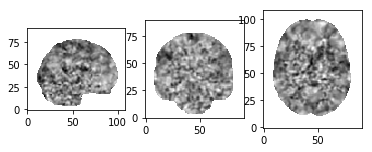

In [7]:
## plot one file as an example

ex = dictdata[57, 2].get_data()

def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

slice_0 = ex[45, :, :]
slice_1 = ex[:, 50, :]
slice_2 = ex[:, :, 45]
show_slices([slice_0, slice_1, slice_2])
plt.show()


In [4]:
# save npy files that are the average across subjects for each seed

listofseeds = np.arange(57, 230) # name of seed files are from 57 to 229
listofsubjects = np.arange(1, 21)

dictforthisseed = {}
for seed in listofseeds:
    for subject in listofsubjects:
        dictforthisseed[subject] = np.ndarray.flatten(dictdata[seed, subject].get_data())
    tableforthisseed = pd.DataFrame.from_dict(dictforthisseed, orient='index')
    median = tableforthisseed.median(axis='index')
    np.save('seedR'+str(seed), np.array(median))
    print('SeedR '+str(seed)+' done!')

SeedR 128 done!
SeedR 129 done!
SeedR 130 done!
SeedR 131 done!
SeedR 132 done!
SeedR 133 done!
SeedR 134 done!
SeedR 135 done!
SeedR 136 done!
SeedR 137 done!
SeedR 138 done!
SeedR 139 done!
SeedR 140 done!
SeedR 141 done!
SeedR 142 done!
SeedR 143 done!
SeedR 144 done!
SeedR 145 done!
SeedR 146 done!
SeedR 147 done!
SeedR 148 done!
SeedR 149 done!


In [5]:
# transform all seed maps into nifti files:
listofseeds = np.arange(57, 230)
for seed in listofseeds:
    ex = np.load('/mnt/c/Users/xavie/Dropbox (MIT)/MIT/_ACTIVE_PROJECTS/Sheeba_64ChDN/DN_150seeds/seedR'+str(seed)+'.npy')
    ex.shape = (91, 109, 91)
    template_for_affine = nib.load('/mnt/c/Users/xavie/Dropbox (MIT)/MIT/_ACTIVE_PROJECTS/Sheeba_64ChDN/DN_150seeds/corr_Subject001_Condition001_Source053.nii')
    img = nib.Nifti1Image(ex, template_for_affine.affine)
    img.to_filename('seedR'+str(seed)+'.nii.gz')

In [6]:
# mask all seed maps:
listofseeds = np.arange(57, 230)
for seed in listofseeds:
    subprocess.check_output('fslmaths seedR'+str(seed)+'.nii.gz -mas networkonlylabels_nocerebellum_bin.nii \
    seedR'+str(seed)+'_CerebralCortexNetworksMask.nii.gz', shell=True);